## Data Preparation 

We use Beeline benchmark to benchmark the performance of DeepSEM.
The data preparation process are shown in below.
1. Download raw data from https://doi.org/10.5281/zenodo.3378975, which is provided by BEELINE benchmark
2. Use the preoprocess code in https://github.com/Murali-group/Beeline/blob/master/generateExpInputs.py to generate dataset.

We also provide demo data as shown in ../demo_data/GRN_inference/input 

# Run DeepSEM by using following command:
for cell type specific GRN inference task: python main.py --task non_celltype_GRN --data_file demo_data/GRN_inference/input/500_STRING_hESC/data.csv --net_file demo_data/GRN_inference/input/500_STRING_hESC/label.csv --setting new --alpha 100 --beta 1 --n_epoch 90 --save_name out


for cell type non-specific GRN inference task: python main.py --task celltype_GRN --data_file demo_data/GRN_inference/input/500_ChIP-seq_hESC/data.csv --net_file demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv --setting new --alpha 0.1 --beta 0.01 --n_epochs 150  --save_name out

In [20]:
#! python ../main.py --task non_celltype_GRN --data_file ../demo_data/GRN_inference/input/500_STRING_hESC/data.csv --net_file ../demo_data/GRN_inference/input/500_STRING_hESC/label.csv --setting new --alpha 100 --beta 1 --n_epoch 90 --save_name out
!python ../main.py --task celltype_GRN --data_file ../demo_data/GRN_inference/input/500_ChIP-seq_hESC/data.csv --net_file ../demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv --setting new --alpha 0.1 --beta 0.01 --n_epochs 150  --save_name out

Using inverse constraint
dir exist
epoch: 1 Ep: 657 Epr: 0.8854646273145838 loss: 0.40524541834990185 mse_loss: 0.37126381198565167 kl_loss: 0.03383117301079134 sparse_loss: 0.0001504377899739969
epoch: 2 Ep: 644 Epr: 0.8679440182505205 loss: 0.382014736533165 mse_loss: 0.34716524680455524 kl_loss: 0.03467311446244518 sparse_loss: 0.00017638627953904992
epoch: 4 Ep: 641 Epr: 0.8639008007741982 loss: 0.1962630165119966 mse_loss: 0.15378108620643616 kl_loss: 0.0422802638883392 sparse_loss: 0.00020166086081493026
epoch: 5 Ep: 631 Epr: 0.8504234091864572 loss: 0.17212274049719176 mse_loss: 0.12743392090002695 kl_loss: 0.044462022526810564 sparse_loss: 0.00022679195535602048
epoch: 7 Ep: 635 Epr: 0.8558143658215536 loss: 0.12627760569254556 mse_loss: 0.07845771685242653 kl_loss: 0.04757408440733949 sparse_loss: 0.0002458036372748514
epoch: 8 Ep: 638 Epr: 0.8598575832978759 loss: 0.11811616457998753 mse_loss: 0.06872863943378131 kl_loss: 0.049126722694685064 sparse_loss: 0.000260804595503335

# Calculate EPR values

In [21]:
import pandas as pd
output = pd.read_csv('out/GRN_inference_result.tsv',sep='\t')
output['EdgeWeight'] = abs(output['EdgeWeight'])
output = output.sort_values('EdgeWeight',ascending=False)
#label = pd.read_csv('../demo_data/GRN_inference/input/500_STRING_hESC/label.csv')
label = pd.read_csv("../demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv")
TFs = set(label['Gene1'])
Genes = set(label['Gene1'])| set(label['Gene2'])
output = output[output['TF'].apply(lambda x: x in TFs)]
output = output[output['Target'].apply(lambda x: x in Genes)]
label_set = set(label['Gene1']+'|'+label['Gene2'])
output = output.iloc[:len(label_set)]
len(set(output['TF']+'|'+output['Target']) & label_set) / (len(label_set)**2/(len(TFs)*len(Genes)-len(TFs)))


1.0606707179552168

# Calculate AUPR ratio values

In [16]:
from sklearn.metrics import average_precision_score, precision_recall_curve
import numpy as np
import pandas as pd
output = pd.read_csv('out/GRN_inference_result.tsv',sep='\t')
output['EdgeWeight'] = abs(output['EdgeWeight'])
output = output.sort_values('EdgeWeight',ascending=False)
#label = pd.read_csv('../demo_data/GRN_inference/input/500_STRING_hESC/label.csv')
label = pd.read_csv("../demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv")
TFs = set(label['Gene1'])
Genes = set(label['Gene1'])| set(label['Gene2'])
output = output[output['TF'].apply(lambda x: x in TFs)]
output = output[output['Target'].apply(lambda x: x in Genes)]
label_set = set(label['Gene1']+'|'+label['Gene2'])
preds,labels,randoms = [] ,[],[]
res_d = {}
l = []
p= []
for item in (output.to_dict('records')):
        res_d[item['TF'] + '|' + item['Target']] = item['EdgeWeight']
for item in (set(label['Gene1'])):
        for item2 in  set(label['Gene1'])| set(label['Gene2']):
            if item+ '|' + item2 in label_set:
                l.append(1)
            else:
                l.append(0)
            if item + '|' + item2 in res_d:
                p.append(res_d[item + '|' + item2])
            else:
                p.append(-1)
                
print("AUPRC = ", average_precision_score(l,p))
print(average_precision_score(l,p)/np.mean(l))
precision, recall, thresholds = precision_recall_curve(l, p)

AUPRC =  0.0327282671986467
1.3633395232800607


Text(0, 0.5, 'precision')

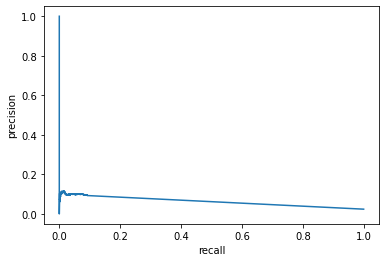

In [11]:
import matplotlib.pyplot as plt
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision")

# Ensemble DeepSEM result

In [52]:
res = []
for i in range(10):
    res.append(pd.read_csv('../../scGRN/Upload/GRN_inference_benchmark/cross_validation/500_STRING_hESC/rep_i.csv',sep='\t'))
res = pd.concat(res)
res['EdgeWeight'] = abs(res['EdgeWeight'])
res.groupby(['Gene1','Gene2']).mean()

FileNotFoundError: [Errno 2] File ../../scGRN/Upload/GRN_inference_benchmark/cross_validation/500_STRING_hESC/rep_i.csv does not exist: '../../scGRN/Upload/GRN_inference_benchmark/cross_validation/500_STRING_hESC/rep_i.csv'